<a href="https://colab.research.google.com/github/IT-17005/Schizophrenia/blob/main/ROC_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
labels = ['non-scz','scz']

In [5]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/SchiFinalDataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/SchiFinalDataset','val',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 320/320 [00:06<00:00, 52.40it/s] 


In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3240, 224, 224, 3)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(input_shape=(image_size,image_size,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

vgg19 = VGG19(input_shape=(image_size,image_size,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

efficientnet = tf.keras.applications.EfficientNetB0(input_shape=(image_size,image_size,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

inceptionv3 = tf.keras.applications.InceptionV3(input_shape=(image_size,image_size,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

resnet50 = ResNet50(input_shape=(image_size,image_size,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
from keras.models import Sequential
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size,image_size,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [12]:
for layer in vgg16.layers:
    layer.trainable = False
model_vgg16 = vgg16.output
model_vgg16 = tf.keras.layers.GlobalAveragePooling2D()(model_vgg16)
model_vgg16 = tf.keras.layers.Dropout(rate=0.5)(model_vgg16)
model_vgg16 = tf.keras.layers.Dense(2,activation='softmax')(model_vgg16)
model_vgg16 = tf.keras.models.Model(inputs=vgg16.input, outputs = model_vgg16)
model_vgg16.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
model_vgg16.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.8116 - accuracy: 0.5330
Epoch 1: val_accuracy improved from -inf to 0.63077, saving model to vgg16.h5
73/73 [==============================] - 28s 202ms/step - loss: 2.8116 - accuracy: 0.5330 - val_loss: 0.8285 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 1.6333 - accuracy: 0.5840
Epoch 2: val_accuracy improved from 0.63077 to 0.73462, saving model to vgg16.h5
73/73 [==============================] - 12s 158ms/step - loss: 1.6333 - accuracy: 0.5840 - val_loss: 0.6144 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 1.0593 - accuracy: 0.6321
Epoch 3: val_accuracy did not improve from 0.73462
73/73 [==============================] - 12s 159ms/step - loss: 1.0593 - accuracy: 0.6321 - val_loss: 0.5782 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.803

In [13]:
for layer in vgg19.layers:
    layer.trainable = False
model_vgg19 = vgg19.output
model_vgg19 = tf.keras.layers.GlobalAveragePooling2D()(model_vgg19)
model_vgg19 = tf.keras.layers.Dropout(rate=0.5)(model_vgg19)
model_vgg19 = tf.keras.layers.Dense(2,activation='softmax')(model_vgg19)
model_vgg19 = tf.keras.models.Model(inputs=vgg19.input, outputs = model_vgg19)
model_vgg19.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
model_vgg19.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.4675 - accuracy: 0.5081
Epoch 1: val_accuracy improved from -inf to 0.61154, saving model to vgg19.h5
73/73 [==============================] - 15s 200ms/step - loss: 2.4675 - accuracy: 0.5081 - val_loss: 0.8933 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 1.4981 - accuracy: 0.5733
Epoch 2: val_accuracy improved from 0.61154 to 0.63462, saving model to vgg19.h5
73/73 [==============================] - 14s 198ms/step - loss: 1.4981 - accuracy: 0.5733 - val_loss: 0.6492 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.6372
Epoch 3: val_accuracy improved from 0.63462 to 0.70000, saving model to vgg19.h5
73/73 [==============================] - 16s 214ms/step - loss: 0.9450 - accuracy: 0.6372 - val_loss: 0.5498 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/20
73/73 [=========================

In [14]:
for layer in efficientnet.layers:
    layer.trainable = False
model_efficientnet = efficientnet.output
model_efficientnet = tf.keras.layers.GlobalAveragePooling2D()(model_efficientnet)
model_efficientnet = tf.keras.layers.Dropout(rate=0.5)(model_efficientnet)
model_efficientnet = tf.keras.layers.Dense(2,activation='softmax')(model_efficientnet)
model_efficientnet = tf.keras.models.Model(inputs=efficientnet.input, outputs = model_efficientnet)
model_efficientnet.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("efficientnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
model_efficientnet.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.7223 - accuracy: 0.5617
Epoch 1: val_accuracy improved from -inf to 0.71923, saving model to efficientnet.h5
73/73 [==============================] - 14s 109ms/step - loss: 0.7223 - accuracy: 0.5617 - val_loss: 0.5913 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6913
Epoch 2: val_accuracy did not improve from 0.71923
73/73 [==============================] - 5s 69ms/step - loss: 0.5891 - accuracy: 0.6913 - val_loss: 0.5593 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.7230
Epoch 3: val_accuracy improved from 0.71923 to 0.74231, saving model to efficientnet.h5
73/73 [==============================] - 6s 76ms/step - loss: 0.5486 - accuracy: 0.7230 - val_loss: 0.5108 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - ETA: 0s - l

In [15]:
for layer in inceptionv3.layers:
    layer.trainable = False
model_inceptionv3 = inceptionv3.output
model_inceptionv3 = tf.keras.layers.GlobalAveragePooling2D()(model_inceptionv3)
model_inceptionv3 = tf.keras.layers.Dropout(rate=0.5)(model_inceptionv3)
model_inceptionv3 = tf.keras.layers.Dense(2,activation='softmax')(model_inceptionv3)
model_inceptionv3 = tf.keras.models.Model(inputs=inceptionv3.input, outputs = model_inceptionv3)
model_inceptionv3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("inceptionv3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
model_inceptionv3.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 10.1004 - accuracy: 0.5180
Epoch 1: val_accuracy improved from -inf to 0.63077, saving model to inceptionv3.h5
73/73 [==============================] - 14s 127ms/step - loss: 10.1004 - accuracy: 0.5180 - val_loss: 2.0707 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 4.6128 - accuracy: 0.6141
Epoch 2: val_accuracy improved from 0.63077 to 0.75385, saving model to inceptionv3.h5
73/73 [==============================] - 6s 88ms/step - loss: 4.6128 - accuracy: 0.6141 - val_loss: 1.5935 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 3.2126 - accuracy: 0.6621
Epoch 3: val_accuracy improved from 0.75385 to 0.77692, saving model to inceptionv3.h5
73/73 [==============================] - 6s 88ms/step - loss: 3.2126 - accuracy: 0.6621 - val_loss: 1.1248 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 4/20
73/73 [=========

In [16]:
for layer in resnet50.layers:
    layer.trainable = False
model_resnet50 = resnet50.output
model_resnet50 = tf.keras.layers.GlobalAveragePooling2D()(model_resnet50)
model_resnet50 = tf.keras.layers.Dropout(rate=0.5)(model_resnet50)
model_resnet50 = tf.keras.layers.Dense(2,activation='softmax')(model_resnet50)
model_resnet50 = tf.keras.models.Model(inputs=resnet50.input, outputs = model_resnet50)
model_resnet50.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
model_resnet50.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.5828
Epoch 1: val_accuracy improved from -inf to 0.67308, saving model to resnet50.h5
73/73 [==============================] - 14s 137ms/step - loss: 0.8851 - accuracy: 0.5828 - val_loss: 0.5593 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.6801
Epoch 2: val_accuracy improved from 0.67308 to 0.80769, saving model to resnet50.h5
73/73 [==============================] - 8s 109ms/step - loss: 0.6249 - accuracy: 0.6801 - val_loss: 0.4318 - val_accuracy: 0.8077 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.7324
Epoch 3: val_accuracy improved from 0.80769 to 0.84231, saving model to resnet50.h5
73/73 [==============================] - 8s 110ms/step - loss: 0.5410 - accuracy: 0.7324 - val_loss: 0.3923 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 4/20
73/73 [==================

In [17]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("ourmodel.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 30.8165 - accuracy: 0.7714
Epoch 1: val_accuracy improved from -inf to 0.89231, saving model to ourmodel.h5
73/73 [==============================] - 7s 71ms/step - loss: 30.8165 - accuracy: 0.7714 - val_loss: 0.2406 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9443
Epoch 2: val_accuracy improved from 0.89231 to 0.98077, saving model to ourmodel.h5
73/73 [==============================] - 4s 57ms/step - loss: 0.1432 - accuracy: 0.9443 - val_loss: 0.0782 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 3/20
72/73 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9727
Epoch 3: val_accuracy improved from 0.98077 to 0.99615, saving model to ourmodel.h5
73/73 [==============================] - 4s 57ms/step - loss: 0.0758 - accuracy: 0.9721 - val_loss: 0.0353 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 4/20
72/73 [====================

In [18]:
# predict probabilities
pred_prob1 = model_vgg16.predict(X_test)
pred_prob2 = model_vgg19.predict(X_test)
pred_prob3 = model_efficientnet.predict(X_test)
pred_prob4 = model_inceptionv3.predict(X_test)
pred_prob5 = model_resnet50.predict(X_test)
pred_prob6 = model.predict(X_test)

In [22]:
y_test = np.argmax(y_test,axis=1)

In [23]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [24]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score_vgg16 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score_vgg19 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score_efficientnet = roc_auc_score(y_test, pred_prob3[:,1])
auc_score_inceptionv3 = roc_auc_score(y_test, pred_prob4[:,1])
auc_score_resnet50 = roc_auc_score(y_test, pred_prob5[:,1])
auc_score_model = roc_auc_score(y_test, pred_prob6[:,1])

print(auc_score_vgg16, auc_score_vgg19, auc_score_efficientnet, auc_score_inceptionv3, auc_score_resnet50, auc_score_model)

0.9230399461616112 0.930606162572706 0.9424890640772965 0.9330961880498007 0.9704754122001634 1.0


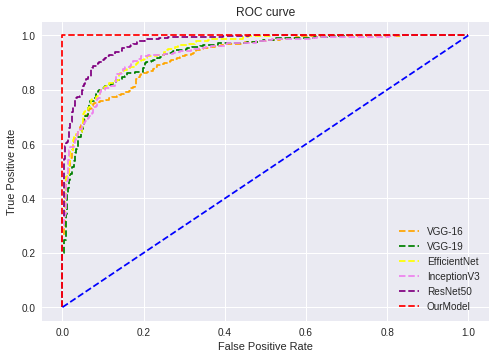

In [25]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='VGG-16')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='VGG-19')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='EfficientNet')
plt.plot(fpr4, tpr4, linestyle='--',color='violet', label='InceptionV3')
plt.plot(fpr5, tpr5, linestyle='--',color='purple', label='ResNet50')
plt.plot(fpr6, tpr6, linestyle='--',color='red', label='OurModel')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();